In [1]:
library(arrow)
library(readxl)
library(showtext)
library(tidyverse)

source("datasets.r")

options(
  lubridate.week.start = 1,
  readr.show_col_types = FALSE
)

font_add(
  family = "Roboto Condensed",
  regular = "RobotoCondensed-Regular.ttf",
  bold = "RobotoCondensed-Bold.ttf"
)
showtext_auto()

theme_set(
  hrbrthemes::theme_ipsum_rc(
    axis_title_size = 12,
    base_size = 12,
    grid = "XY"
  )
)

colour_solar <- "#f2b130"
colour_solar_dark <- "#be9e5c"
colour_wind <- "dodgerblue"


Some features are not enabled in this build of Arrow. Run `arrow_info()` for more information.


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Loading required package: sysfonts

Loading required package: showtextdb

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data loading


### Installed capacities

Historical installed capacities are pulled from ERÚ and hardcoded here. Projected installed capacities for PECD-based analyses are pulled from ERAA 2023.


In [2]:
# Historical installed capacities for use with the ENTSO-E data.
df_installed_entsoe <- tribble(
  ~ Source, ~ Year, ~ InstalledMW,
  "Onshore", 2015, 278,
  "Onshore", 2016, 282,
  "Onshore", 2017, 308,
  "Onshore", 2018, 317,
  "Onshore", 2019, 339,
  "Onshore", 2020, 339,
  "Onshore", 2021, 339,
  "Onshore", 2022, 339,
  "Onshore", 2023, 343,
  "Solar", 2015, 2078,
  "Solar", 2016, 2076,
  "Solar", 2017, 2077,
  "Solar", 2018, 2062,
  "Solar", 2019, 2069,
  "Solar", 2020, 2080,
  "Solar", 2021, 2088,
  "Solar", 2022, 2082,
  "Solar", 2023, 2800  # Approximately.
)

zone_to_country_code <- \(zone) substr(zone, 1, 2)

load_pemmdb_capacities <- \(target_year) {
  data_file_path("ERAA2023 PEMMDB Generation.xlsx") |>
  read_xlsx(
    sheet = str_glue("TY{target_year}"),
    range = "B2:BE25"
  ) |>
    rename(Source = 1) |>
    filter(Source %in% c("Solar (Photovoltaic)", "Wind Offshore", "Wind Onshore")) |>
    mutate(
      Source = case_match(
        Source,
        "Solar (Photovoltaic)" ~ "Solar",
        "Wind Offshore" ~ "Offshore",
        "Wind Onshore" ~ "Onshore"
      )
    ) |>
    pivot_longer(!Source, names_to = "Zone", values_to = "CapacityMW") |>
    filter(CapacityMW > 0) |>
    group_by(
      Source,
      Country = zone_to_country_code(Zone)
    ) |>
    summarise(CapacityMW = sum(CapacityMW), .groups = "drop")
}

# Projected installed capacities from ERAA data for use
# with the PECD time series.
df_installed_pecd <- load_pemmdb_capacities(target_year = 2025)


### Historical data from ENTSO-E

Load historical generation and demand time series from the ENTSO-E Transparency Platform and rescale generation to capacity factors.


In [3]:
cz_entsoe <- (2015:2023) |>
  map(
    ~ load_dataset_entsoe("CZ", .x) |>
        select(Date, Demand = Load, Nuclear, Onshore, Solar) |>
        mutate(
          # There are a couple of hours with zero load, replace those with linear
          # approximation (the mean of the two neighbouring hours if there's only
          # one missing).
          across(Demand, ~ if_else(.x == 0, NA, .x) |> zoo::na.approx(maxgap = 2))
        )
  ) |>
  list_rbind() |>
  mutate(
    Year = year(Date),
    Month = month(Date)
  ) |>
  left_join(
    pivot_wider(
      df_installed_entsoe,
      names_from = Source,
      names_prefix = "Installed",
      values_from = InstalledMW
    ),
    join_by(Year)
  ) |>
  mutate(
    Nuclear = Nuclear / 4047,
    Onshore = Onshore / InstalledOnshore,
    Solar = Solar / InstalledSolar
  ) |>
  select(!starts_with("Installed"))

num_years <- length(unique(cz_entsoe$Year))


### Simulated data from PECD

Load simulated generation and demand time series from the Pan-European Climate Database (PECD). First, load the European-wide generation.


In [4]:
# Multiply capacity factors by assumed installed capacities in the target
# year from the "PEMMDB Generation" spreadsheet.
df_europe_offshore <- data_file_path("PECD-ERAA2023-Wind_Offshore-2025.parquet") |>
  read_parquet() |>
  right_join(
    filter(df_installed_pecd, Source == "Offshore"),
    join_by(country == Country)
  ) |>
  summarise(
    Offshore = sum(cf * CapacityMW),
    .by = year:hour
  ) |>
  arrange(year, month, day, hour)

df_europe_onshore <- data_file_path("PECD-ERAA2023-Wind_Onshore-2025.parquet") |>
  read_parquet() |>
  right_join(
    filter(df_installed_pecd, Source == "Onshore"),
    join_by(country == Country)
  ) |>
  summarise(
    Onshore = sum(cf * CapacityMW),
    .by = year:hour
  ) |>
  arrange(year, month, day, hour)

df_europe_daily_wind <- inner_join(
    df_europe_offshore |> summarise(across(Offshore, sum), .by = year:day),
    df_europe_onshore |> summarise(across(Onshore, sum), .by = year:day),
    join_by(year, month, day)
  ) |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    Wind = (Offshore + Onshore) / 1e3
  )

df_europe_daily_solar <- data_file_path("PECD-ERAA2023-LFSolarPV-2025.parquet") |>
  read_parquet() |>
  right_join(
    filter(df_installed_pecd, Source == "Solar"),
    join_by(country == Country)
  ) |>
  summarise(
    Solar = sum(cf * CapacityMW),
    .by = year:hour
  ) |>
  arrange(year, month, day, hour) |>
  summarise(across(Solar, sum), .by = year:day) |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    Solar = Solar / 1e3
  )


Next, load the simulated generation in Czechia as well.


In [46]:
df_cz_daily_solar_pecd <- data_file_path("PECD-ERAA2023-LFSolarPV-2025.parquet") |>
  read_parquet() |>
  filter(country == "CZ") |>
  summarise(
    across(cf, mean),
    .by = year:day
  ) |>
  arrange(year, month, day) |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    SolarCf = cf
  )

df_cz_daily_wind_pecd <- data_file_path("PECD-ERAA2023-Wind_Onshore-2025.parquet") |>
  read_parquet() |>
  filter(country == "CZ") |>
  summarise(
    across(cf, mean),
    .by = year:day
  ) |>
  arrange(year, month, day) |>
  transmute(
    Date = ymd(paste(year, month, day, sep = "-")),
    Year = year,
    Month = month,
    DayOfYear = yday(Date),
    WindCf = cf
  )



## Charts


### Shortages


In [6]:
demand_factor <- 1.6
nuclear_installed_gw <- 5
solar_installed_gw <- 25
wind_installed_gw <- 15

df_shortages <- cz_entsoe |>
  mutate(
    Demand = demand_factor * Demand,
    Nuclear = nuclear_installed_gw * 1000 * Nuclear,
    Onshore = wind_installed_gw * 1000 * Onshore,
    Solar = solar_installed_gw * 1000 * Solar,
    Residual = Demand - Nuclear - Onshore - Solar,
    Shortage = pmin(0, Residual)
  )


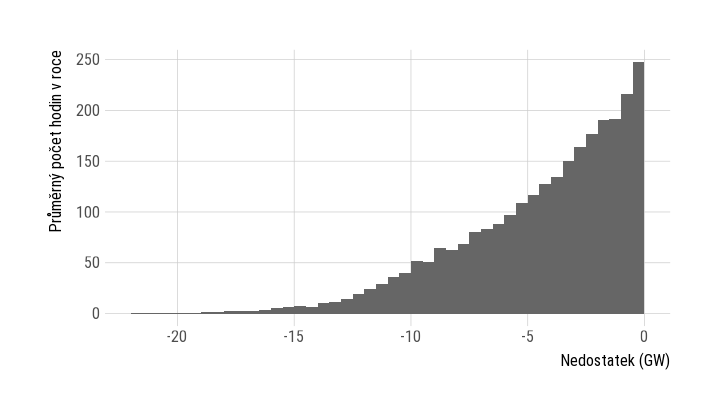

In [7]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

df_shortages |>
  filter(Shortage < 0) |>
  ggplot(aes(Shortage / 1e3, after_stat(count) / num_years)) +
  geom_histogram(
    fill = "grey40",
    binwidth = .5,
    boundary = 0
  ) +
  labs(
    x = "Nedostatek (GW)",
    y = "Průměrný počet hodin v roce"
  )


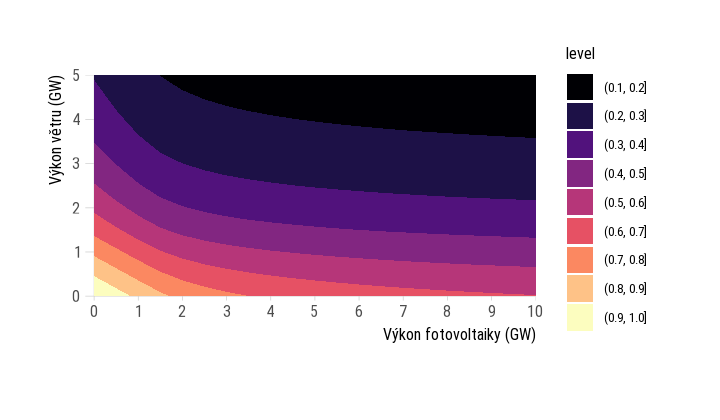

In [8]:
calculate_shortage_cf <- function(df, onshore, solar) {
  df |>
    mutate(
      Onshore = onshore * Onshore,
      Solar = solar * Solar,
      Renewables = Onshore + Solar,
      Shortage = pmax(0, 1 - Renewables)
    ) |>
    pull(Shortage) |>
    mean()
}

df_shortage_cf <- expand_grid(
  InstalledOnshore = seq(0, 5, .25),
  InstalledSolar = seq(0, 10, .5)
) |>
  rowwise() |>
  mutate(
    ShortageCf = calculate_shortage_cf(
      cz_entsoe,
      onshore = InstalledOnshore,
      solar = InstalledSolar
    )
  )

options(repr.plot.height = 3.5, repr.plot.width = 6)

df_shortage_cf |>
  unnest(ShortageCf) |>
  rename(ShortageCf = 3) |>
  ggplot(aes(InstalledSolar, InstalledOnshore)) +
  geom_contour_filled(aes(z = ShortageCf)) +
  scale_x_continuous(
    "Výkon fotovoltaiky (GW)",
    breaks = seq(0, 10, 1),
    expand = expansion(mult = c(.02, 0))
  ) +
  scale_y_continuous(
    "Výkon větru (GW)",
    expand = expansion(mult = c(.02, 0))
  ) +
  scale_fill_viridis_d(option = "magma") +
  coord_fixed()


### Solar PV – distribution \& surpluses, extrapolated historical data

First, a bit of data preparation, scaling and so on.


In [9]:
solar_installed_seq <- seq(10, 40, 5)

df_solar_used <- solar_installed_seq |>
  map(
    ~ cz_entsoe |>
        mutate(
          Demand = demand_factor * Demand,
          Nuclear = nuclear_installed_gw * 1000 * Nuclear,
          Onshore = wind_installed_gw * 1000 * Onshore,
          Solar = .x * 1000 * Solar,
          Residual = Demand - Nuclear - Onshore - Solar,
          SurplusSolar = pmax(0, -Residual * Solar / (Onshore + Solar))
        ) |>
        summarise(
          SolarInstalledGW = .x,
          TotalSolar = sum(Solar) / 1e6,
          SurplusSolar = sum(SurplusSolar, na.rm = TRUE) / 1e6,
          .by = Year
        )
  ) |>
  list_rbind()

# Distribution of surplus production.
df_solar_surpluses <- cz_entsoe |>
  mutate(
    Demand = demand_factor * Demand,
    Nuclear = nuclear_installed_gw * 1000 * Nuclear,
    Onshore = wind_installed_gw * 1000 * Onshore,
    Solar = 25 * 1000 * Solar,
    Residual = Demand - Nuclear - Onshore - Solar,
    SurplusTotal = pmax(0, -Residual),
    SurplusSolar = SurplusTotal * Solar / (Onshore + Solar),
  )


Now for the distribution of surpluses as a a) histogram, b) CDF, and c) duration curve.


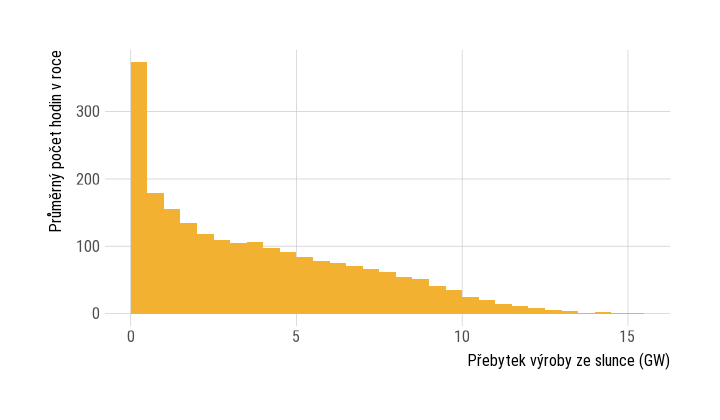

In [10]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

# a. Histogram.
df_solar_surpluses |>
  filter(SurplusSolar > 0) |>
  ggplot(aes(SurplusSolar / 1e3, after_stat(count) / num_years)) +
  geom_histogram(
    fill = colour_solar,
    binwidth = .5,
    boundary = 0
  ) +
  labs(
    x = "Přebytek výroby ze slunce (GW)",
    y = "Průměrný počet hodin v roce"
  )


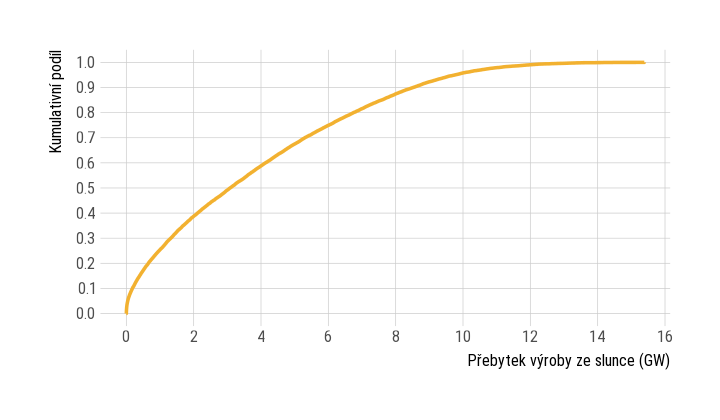

In [11]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

# b. CDF.
df_solar_surpluses |>
  filter(SurplusSolar > 0) |>
  ggplot(aes(SurplusSolar / 1e3)) +
  stat_ecdf(
    colour = colour_solar,
    linewidth = 1,
    pad = FALSE
  ) +
  scale_x_continuous("Přebytek výroby ze slunce (GW)", breaks = seq(0, 20, 2)) +
  scale_y_continuous("Kumulativní podíl", breaks = seq(0, 1, .1))


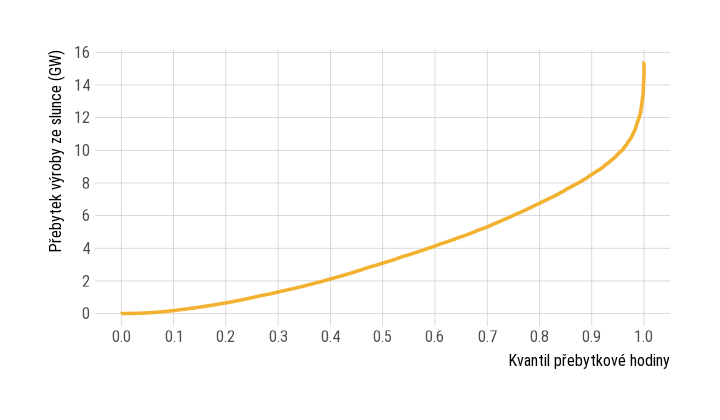

In [12]:
options(repr.plot.height = 3.5, repr.plot.width = 6)

# c. Duration curve.
df_solar_surpluses |>
  filter(SurplusSolar > 0) |>
  ggplot(aes(SurplusSolar / 1e3)) +
  stat_ecdf(
    colour = colour_solar,
    linewidth = 1,
    pad = FALSE
  ) +
  scale_x_continuous(breaks = seq(0, 20, 2)) +
  scale_y_continuous(breaks = seq(0, 1, .1)) +
  coord_flip() +
  labs(
    x = "Přebytek výroby ze slunce (GW)",
    y = "Kvantil přebytkové hodiny"
  )


The following show the correlation of solar production and total surplus production. It is mainly solar that causes surplus production.


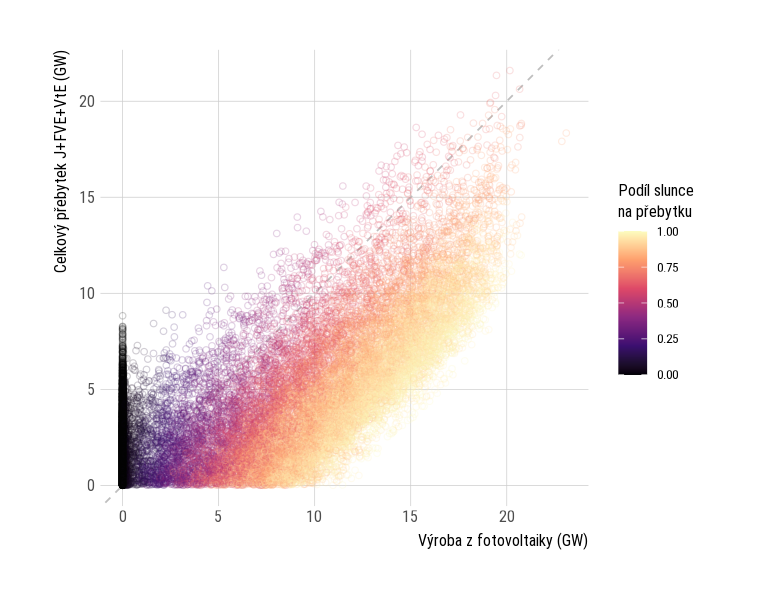

In [13]:
options(repr.plot.height = 5, repr.plot.width = 6.5)

df_solar_surpluses |>
  mutate(SurplusTotal = pmax(0, -Residual)) |>
  filter(SurplusTotal > 0) |>
  ggplot(aes(Solar / 1e3, SurplusTotal / 1e3)) +
  geom_abline(slope = 1, colour = "grey", linetype = "dashed") +
  geom_point(
    aes(colour = Solar / (Solar + Onshore)),
    shape = 1,
    alpha = .2
  ) +
  scale_colour_viridis_c(
    "Podíl slunce\nna přebytku",
    option = "magma",
    limits = c(0, 1)
  ) +
  coord_fixed() +
  labs(
    x = "Výroba z fotovoltaiky (GW)",
    y = "Celkový přebytek J+FVE+VtE (GW)"
  )


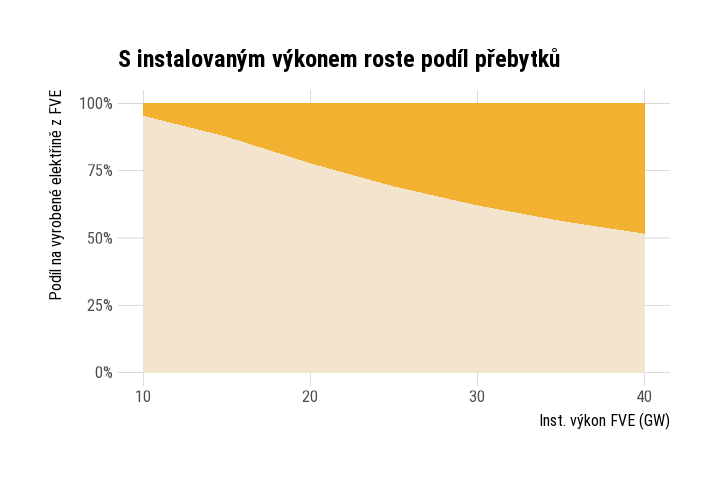

In [14]:
options(repr.plot.height = 4, repr.plot.width = 6)

df_solar_used |>
  summarise(
    Surplus = mean(SurplusSolar),
    Used = mean(TotalSolar - SurplusSolar),
    .by = SolarInstalledGW
  ) |>
  pivot_longer(
    !SolarInstalledGW,
    names_to = "Category",
    values_to = "Volume"
  ) |>
  ggplot(aes(SolarInstalledGW, Volume)) +
  geom_area(aes(fill = Category), position = "fill") +
  scale_y_continuous(
    "Podíl na vyrobené elektřině z FVE",
    labels = scales::label_percent()
  ) +
  scale_fill_manual(
    guide = "none",
    values = c(Surplus = colour_solar, Used = "#f3e5cd")
  ) +
  labs(
    title = "S instalovaným výkonem roste podíl přebytků",
    x = "Inst. výkon FVE (GW)"
  ) +
  expand_limits(y = 0)


### Solar PV – Czechia, historical

These charts are limited to the period between April and September (inclusive).


In [15]:
df_solar_cz_daily <- cz_entsoe |>
  mutate(Date = as_date(Date)) |>
  summarise(SolarCf = mean(Solar), .by = Date) |>
  mutate(
    Year = year(Date),
    Month = month(Date),
    DayOfYear = yday(Date)
  ) |>
  filter(between(DayOfYear, 91, 274)) |>
  mutate(SolarRelative = SolarCf / mean(SolarCf[between(DayOfYear, 91, 274)]))

scales_solar_cz_daily <- function(ylim = c(0, 3)) {
  list(
    scale_x_continuous(
      "Den v roce",
      breaks = cumsum(c(91, 30, 31, 30, 31, 31, 30)),
      labels = c("duben", "květen", "červen", "červenec", "srpen", "září", "říjen"),
      expand = expansion(mult = .02)
    ),
    scale_y_continuous(
      "Výroba z FV oproti dlouhodobému průměru",
      breaks = seq(0, 2.5, .5),
      labels = scales::label_percent(decimal.mark = ",", suffix = " %"),
      limits = ylim
    )
  )
}


In [16]:
df_solar_cz_daily |>
  mutate(SolarRelative = SolarCf / mean(SolarCf[between(DayOfYear, 91, 274)])) |>
  summarise(Y = sum(SolarRelative < .5), .by = Year) |>
  # ggplot(aes(Year, Y)) + geom_col()
  pull(Y) |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      7      13      17      16      19      23 

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


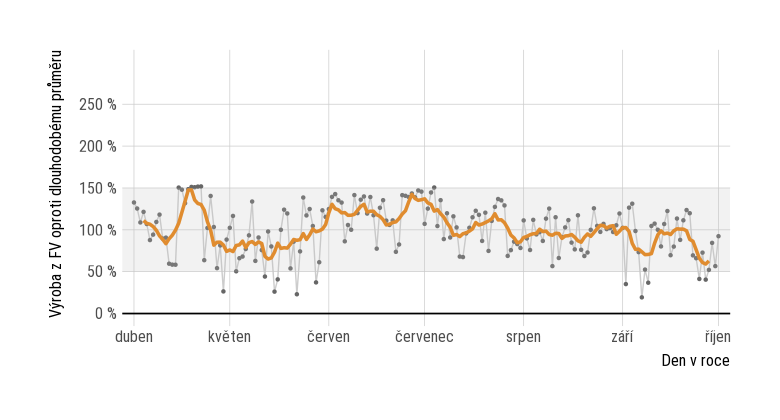

In [17]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_solar_cz_daily |>
  filter(Year == 2019) |>
  ggplot(aes(DayOfYear, SolarRelative)) +
  geom_line(colour = "grey80", linewidth = .4) +
  geom_point(colour = "grey40", size = .6) +
  # geom_rect(
  #   aes(ymin = q10, ymax = q90),
  #   data = ~ .x |>
  #       summarise(
  #         q10 = quantile(SolarRelative, .1),
  #         q90 = quantile(SolarRelative, .9)
  #       ),
  #   xmin = -Inf,
  #   xmax = Inf,
  #   fill = colour_solar,
  #   alpha = .2,
  #   inherit.aes = FALSE
  # ) +
  # stat_summary_bin(
  #   geom = "step",
  #   binwidth = 7,
  #   colour = colour_solar,
  #   linewidth = 1,
  #   direction = "mid",
  #   fun = mean
  # ) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    data = ~ mutate(.x, SolarRelative = zoo::rollmean(SolarRelative, k = 7, na.pad = TRUE)),
    colour = "#e08c2f",
    linewidth = 1
  ) +
  geom_hline(yintercept = 0) +
  scales_solar_cz_daily()


In [18]:
df_solar_cz_daily |>
  summarise(sum(SolarRelative < .5), .by = Year)


Year,sum(SolarRelative < 0.5)
<dbl>,<int>
2015,14
2016,13
2017,22
2018,7
2019,11
2020,18
2021,19
2022,17
2023,23


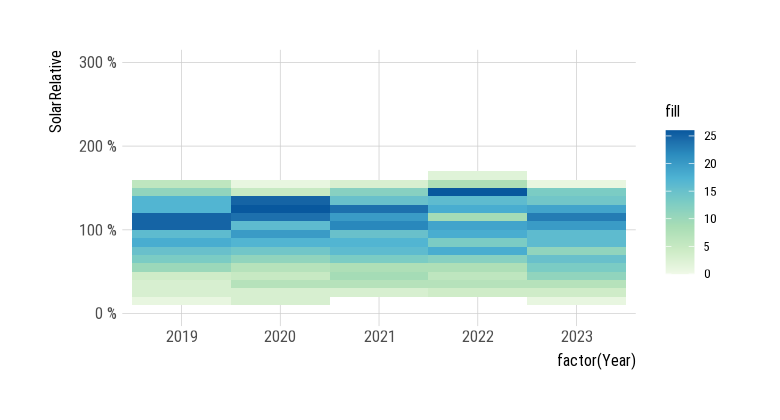

In [19]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_solar_cz_daily |>
  filter(Year >= 2019) |>
  ggplot(aes(factor(Year), SolarRelative)) +
  geom_bin_2d(binwidth = c(1, .1)) +
  # scale_fill_viridis_c(option = "magma", direction = -1) +
  scale_fill_distiller(palette = "GnBu", direction = 1) +
  scale_y_continuous(labels = scales::label_percent(suffix = " %"), limits = c(0, 3)) +
  expand_limits(fill = 0)


Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_line()`).”


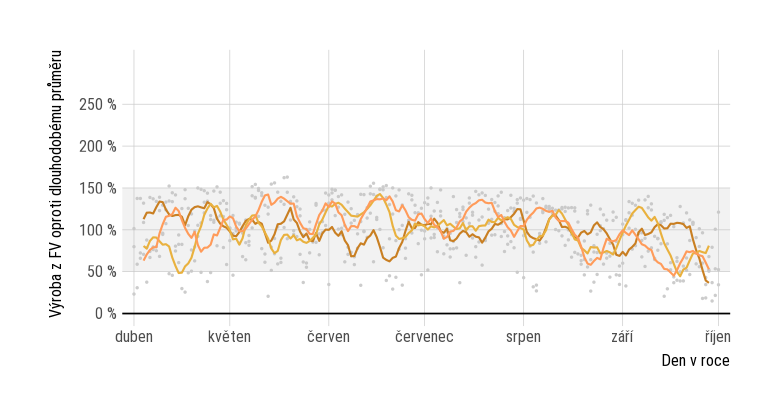

In [20]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_solar_cz_daily |>
  filter(between(Year, 2020, 2022)) |>
  ggplot(aes(DayOfYear, SolarRelative)) +
  geom_point(colour = "grey80", size = .3) +
  # geom_rect(
  #   aes(ymin = q10, ymax = q90),
  #   data = ~ .x |>
  #       summarise(
  #         q10 = quantile(SolarRelative, .1),
  #         q90 = quantile(SolarRelative, .9)
  #       ),
  #   xmin = -Inf,
  #   xmax = Inf,
  #   fill = colour_solar,
  #   alpha = .1,
  #   inherit.aes = FALSE
  # ) +
  # stat_summary_bin(
  #   aes(group = Year, colour = factor(Year)),
  #   geom = "step",
  #   binwidth = 7,
  #   linewidth = .6,
  #   direction = "mid",
  #   fun = mean
  # ) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    aes(colour = factor(Year), group = Year),
    data = ~ .x |> group_by(Year) |> mutate(SolarRelative = zoo::rollmean(SolarRelative, k = 7, na.pad = TRUE)),
    linewidth = .6
  ) +
  geom_hline(yintercept = 0) +
  scale_colour_manual(guide = "none", values = c("#C97F22", "#E9B13E", "#FF9B5A")) +
  scales_solar_cz_daily()


### Solar PV – Czechia, simulated


In [21]:
df_cz_daily_solar_pecd |>
  filter(between(DayOfYear, 91, 274)) |>
  mutate(SolarRelative = SolarCf / mean(SolarCf)) |>
  summarise(
    Less25 = sum(SolarRelative < .25),
    Less50 = sum(SolarRelative < .5),
    .by = Year
  ) |>
  reframe(across(Less25 | Less50, ~ summary(.x)))


Less25  <NA>     Less50  <NA>    
1 Min.    0.000000 Min.     2.00000
2 1st Qu. 1.000000 1st Qu. 11.00000
3 Median  3.000000 Median  14.50000
4 Mean    2.947368 Mean    15.23684
5 3rd Qu. 4.000000 3rd Qu. 18.00000
6 Max.    7.000000 Max.    29.00000

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


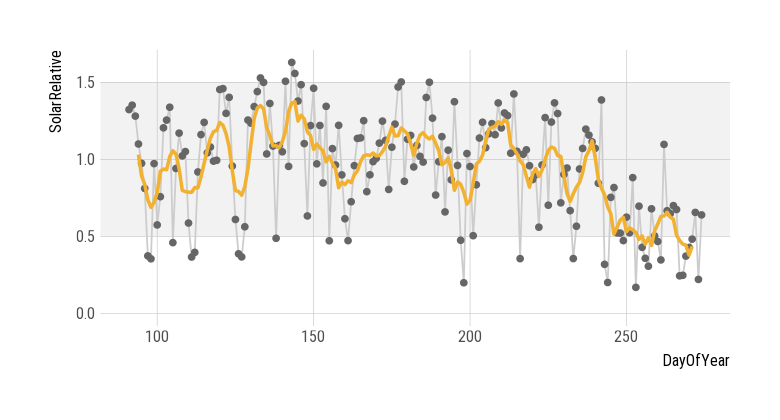

In [22]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_cz_daily_solar_pecd |>
  filter(between(DayOfYear, 91, 274)) |>
  mutate(SolarRelative = SolarCf / mean(SolarCf[between(DayOfYear, 91, 274)])) |>
  filter(Year == 2001) |>
  ggplot(aes(DayOfYear, SolarRelative)) +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = .5, ymax = 1.5, fill = "grey", alpha = .2) +
  geom_line(colour = "grey80") +
  geom_point(colour = "grey40") +
  geom_line(
    colour = colour_solar,
    data = ~ .x |> mutate(SolarRelative = zoo::rollmean(SolarRelative, k = 7, na.pad = TRUE)),
    linewidth = 1
  ) +
  expand_limits(y = 0)


Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_line()`).”


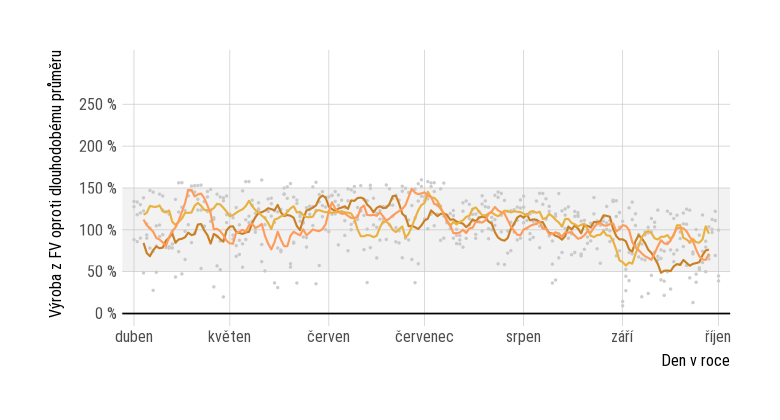

In [23]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_cz_daily_solar_pecd |>
  filter(between(DayOfYear, 91, 274)) |>
  mutate(SolarRelative = SolarCf / mean(SolarCf)) |>
  filter(Year %in% 2017:2019) |>
  ggplot(aes(DayOfYear, SolarRelative)) +
  geom_point(colour = "grey80", size = .3) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    aes(colour = factor(Year), group = Year),
    data = ~ .x |> group_by(Year) |> mutate(SolarRelative = zoo::rollmean(SolarRelative, k = 7, na.pad = TRUE)),
    linewidth = .6
  ) +
  geom_hline(yintercept = 0) +
  scale_colour_manual(guide = "none", values = c("#C97F22", "#E9B13E", "#FF9B5A")) +
  scales_solar_cz_daily()


In [ ]:
df_cz_daily_solar_pecd |>
  summarise(across(SolarCf, mean), .by = Year) |>
  mutate(SolarRelative = SolarCf / mean(SolarCf)) |>
  # pull(SolarRelative) |> stem()
  slice_max(SolarRelative, n = 5)


Year,SolarCf,SolarRelative
<int>,<dbl>,<dbl>
2003,0.1412017,1.116105
2006,0.1354708,1.070807
2011,0.1343762,1.062154
2018,0.1343620,1.062042
2005,0.1329794,1.051114


### Solar PV – Europe, simulated


Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_line()`).”


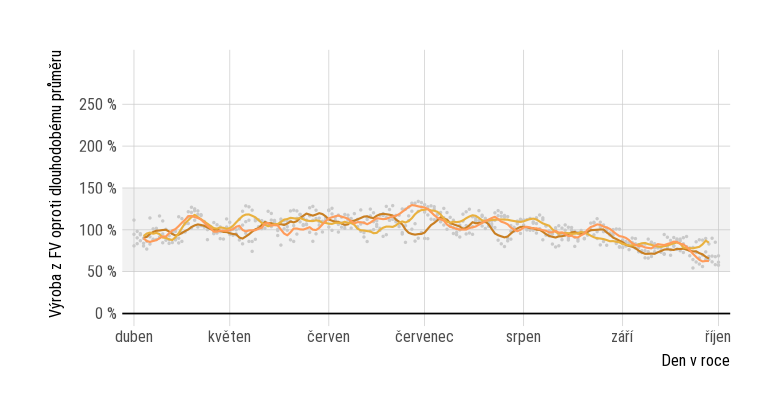

In [24]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_europe_daily_solar |>
  filter(
    between(Year, 2017, 2019),
    between(DayOfYear, 91, 274)
  ) |>
  mutate(SolarRelative = Solar / mean(Solar)) |>
  ggplot(aes(DayOfYear, SolarRelative)) +
  geom_point(colour = "grey80", size = .3) +
  # geom_rect(
  #   aes(ymin = q10, ymax = q90),
  #   data = ~ .x |>
  #       summarise(
  #         q10 = quantile(SolarRelative, .1),
  #         q90 = quantile(SolarRelative, .9)
  #       ),
  #   xmin = -Inf,
  #   xmax = Inf,
  #   fill = colour_solar,
  #   alpha = .1,
  #   inherit.aes = FALSE
  # ) +
  # stat_summary_bin(
  #   aes(group = Year, colour = factor(Year)),
  #   geom = "step",
  #   binwidth = 7,
  #   linewidth = .6,
  #   direction = "mid",
  #   fun = mean
  # ) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    aes(colour = factor(Year), group = Year),
    data = ~ .x |> group_by(Year) |> mutate(SolarRelative = zoo::rollmean(SolarRelative, k = 7, na.pad = TRUE)),
    linewidth = .6
  ) +
  geom_hline(yintercept = 0) +
  scale_colour_manual(guide = "none", values = c("#C97F22", "#E9B13E", "#FF9B5A")) +
  scales_solar_cz_daily(ylim = c(0, 3))


### Wind – Czechia, historical


In [25]:
df_wind_cz_daily <- cz_entsoe |>
  mutate(Date = as_date(Date)) |>
  summarise(WindCf = mean(Onshore), .by = Date) |>
  mutate(
    DayOfYear = if_else(
      month(Date) <= 6,
      365 + yday(Date),
      yday(Date)
    ),
    Year = if_else(DayOfYear > 365, year(Date) - 1, year(Date))
  ) |>
  filter(between(DayOfYear, 274, 457)) |>
  arrange(Year, DayOfYear) |>
  mutate(WindRelative = WindCf / mean(WindCf))

scales_wind_cz_daily <- function(ylim = c(0, 3)) {
  list(
    scale_x_continuous(
      "Den v roce",
      breaks = cumsum(c(274, 31, 30, 31, 31, 29, 31)),
      labels = c("říjen", "listopad", "prosinec", "leden", "únor", "březen", "duben"),
      expand = expansion(mult = .02)
    ),
    scale_y_continuous(
      "Výroba z větru oproti dlouhodobému průměru",
      breaks = seq(0, 2.5, .5),
      labels = scales::label_percent(decimal.mark = ",", suffix = " %"),
      limits = ylim
    )
  )
}


In [26]:
df_wind_cz_daily |>
  summarise(
    Less25 = sum(WindRelative < .25),
    Less50 = sum(WindRelative < .5),
    .by = Year
  ) |>
  reframe(across(Less25 | Less50, ~ summary(.x)))


Less25  <NA>  Less50  <NA> 
1 Min.     1.00 Min.    14.00
2 1st Qu.  8.00 1st Qu. 32.75
3 Median  14.00 Median  46.00
4 Mean    11.80 Mean    42.50
5 3rd Qu. 16.75 3rd Qu. 53.25
6 Max.    19.00 Max.    72.00

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


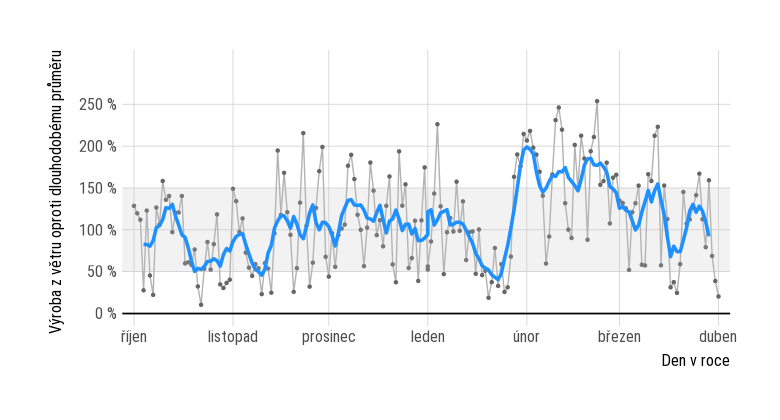

In [27]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_wind_cz_daily |>
  filter(Year == 2019) |>
  ggplot(aes(DayOfYear, WindRelative)) +
  geom_line(colour = "grey70", linewidth = .4) +
  geom_point(colour = "grey40", size = .6) +
  # geom_rect(
  #   aes(ymin = q10, ymax = q90),
  #   data = ~ .x |>
  #       summarise(
  #         q10 = quantile(WindRelative, .1),
  #         q90 = quantile(WindRelative, .9)
  #       ),
  #   xmin = -Inf,
  #   xmax = Inf,
  #   fill = colour_wind,
  #   alpha = .2,
  #   inherit.aes = FALSE
  # ) +
  # stat_summary_bin(
  #   geom = "step",
  #   binwidth = 7,
  #   colour = colour_wind,
  #   linewidth = 1,
  #   direction = "mid",
  #   fun = mean
  # ) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    data = ~ mutate(.x, WindRelative = zoo::rollmean(WindRelative, k = 7, na.pad = TRUE)),
    colour = colour_wind,
    linewidth = 1
  ) +
  geom_hline(yintercept = 0) +
  scales_wind_cz_daily()


Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_tile()`).”


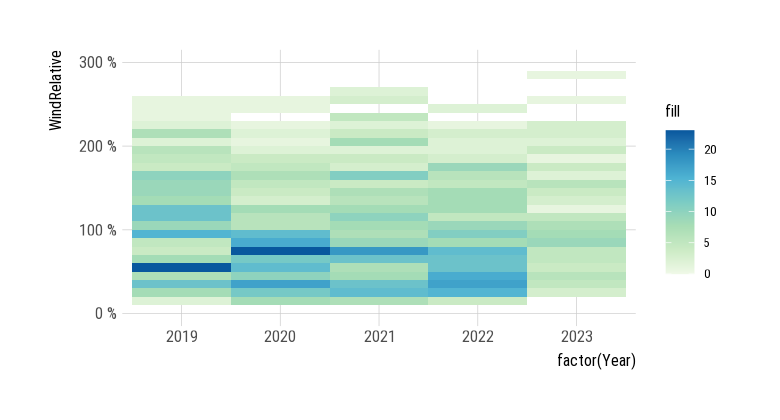

In [28]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_wind_cz_daily |>
  filter(Year >= 2019) |>
  ggplot(aes(factor(Year), WindRelative)) +
  geom_bin_2d(binwidth = c(1, .1)) +
  # scale_fill_viridis_c(option = "magma", direction = -1) +
  scale_fill_distiller(palette = "GnBu", direction = 1) +
  scale_y_continuous(labels = scales::label_percent(suffix = " %"), limits = c(0, 3)) +
  expand_limits(fill = 0)


In [29]:
df_wind_cz_daily |>
  filter(between(DayOfYear, 274, 457), between(Year, 2020, 2022)) |>
  group_by(Week = isoweek(Date)) |>
  summarise(WindRelative = mean(WindRelative)) |> summarise(q10 = quantile(WindRelative, .1), q90 = quantile(WindRelative, .9))


q10,q90
<dbl>,<dbl>
0.7215819,1.329666


Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_line()`).”


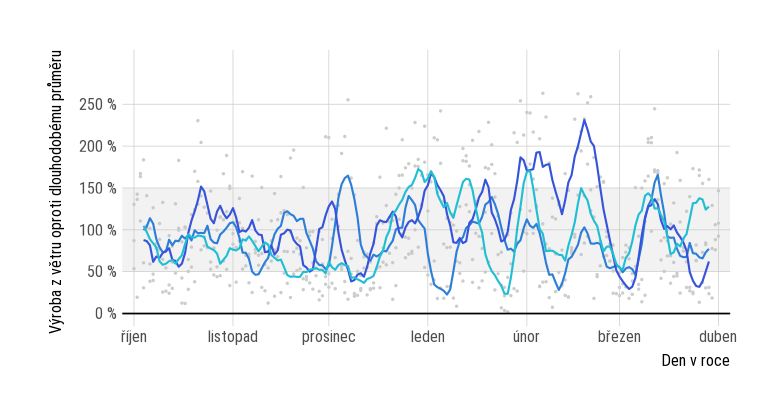

In [30]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_wind_cz_daily |>
  filter(
    between(Year, 2020, 2022),
    between(DayOfYear, 274, 457)
  ) |>
  ggplot(aes(DayOfYear, WindRelative)) +
  geom_point(colour = "grey80", size = .3) +
  # geom_rect(
  #   aes(ymin = q10, ymax = q90),
  #   data = ~ .x |>
  #       summarise(
  #         q10 = quantile(WindRelative, .1),
  #         q90 = quantile(WindRelative, .9)
  #       ),
  #   xmin = -Inf,
  #   xmax = Inf,
  #   fill = colour_wind,
  #   alpha = .1,
  #   inherit.aes = FALSE
  # ) +
  # stat_summary_bin(
  #   aes(group = Year, colour = factor(Year)),
  #   geom = "step",
  #   binwidth = 7,
  #   linewidth = .6,
  #   direction = "mid",
  #   fun = mean
  # ) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    aes(colour = factor(Year)),
    data = ~ .x |> group_by(Year) |> arrange(DayOfYear) |> mutate(WindRelative = zoo::rollmean(WindRelative, k = 7, na.pad = TRUE)),
    linewidth = .6
  ) +
  geom_hline(yintercept = 0) +
  scale_colour_manual(guide = "none", values = c("#2C7ED8", "#3553DB", "#20BED4")) +
  scales_wind_cz_daily()


### Wind – Europe, simulated


Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_line()`).”


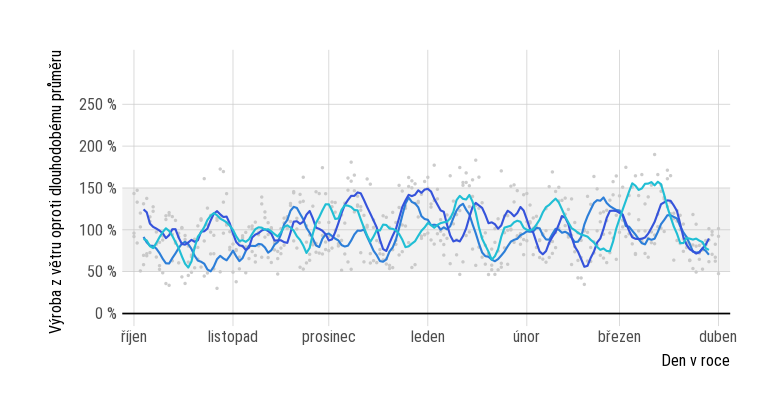

In [31]:
options(repr.plot.height = 3.5, repr.plot.width = 6.5)

df_europe_daily_wind |>
  mutate(
    DayOfYear = if_else(
      Month <= 6,
      365 + DayOfYear,
      DayOfYear
    ),
    Year = if_else(DayOfYear > 365, year(Date) - 1, year(Date))
  ) |>
  arrange(Year, DayOfYear) |>
  filter(
    between(Year, 2016, 2018),
    between(DayOfYear, 274, 457)
  ) |>
  mutate(WindRelative = Wind / mean(Wind)) |>
  ggplot(aes(DayOfYear, WindRelative)) +
  geom_point(colour = "grey80", size = .3) +
  # geom_rect(
  #   aes(ymin = q10, ymax = q90),
  #   data = ~ .x |>
  #       summarise(
  #         q10 = quantile(WindRelative, .1),
  #         q90 = quantile(WindRelative, .9)
  #       ),
  #   xmin = -Inf,
  #   xmax = Inf,
  #   fill = colour_wind,
  #   alpha = .1,
  #   inherit.aes = FALSE
  # ) +
  # stat_summary_bin(
  #   aes(group = Year, colour = factor(Year)),
  #   geom = "step",
  #   binwidth = 7,
  #   linewidth = .6,
  #   direction = "mid",
  #   fun = mean
  # ) +
  annotate(
    "rect",
    ymin = .5, ymax = 1.5,
    xmin = -Inf,
    xmax = Inf,
    fill = "grey",
    alpha = .2
  ) +
  geom_line(
    aes(group = Year, colour = factor(Year)),
    data = ~ .x |> group_by(Year) |> arrange(DayOfYear) |> mutate(WindRelative = zoo::rollmean(WindRelative, k = 7, na.pad = TRUE)),
    linewidth = .6
  ) +
  geom_hline(yintercept = 0) +
  scale_colour_manual(guide = "none", values = c("#2C7ED8", "#3553DB", "#20BED4")) +
  scales_wind_cz_daily(ylim = c(0, 3))


### Solar PV – Czechia, simulated


In [52]:
df_cz_daily_wind_pecd |>
  summarise(across(WindCf, mean), .by = Year) |>
  mutate(WindRelative = WindCf / mean(WindCf)) |>
  # pull(WindRelative) |> stem()
  slice_max(WindRelative, n = 5)


Year,WindCf,WindRelative
<int>,<dbl>,<dbl>
1998,0.3122091,1.166118
1983,0.3044395,1.137098
2007,0.3001473,1.121066
1988,0.2928058,1.093646
1993,0.2922921,1.091727


### Hourly PV and wind consolidated


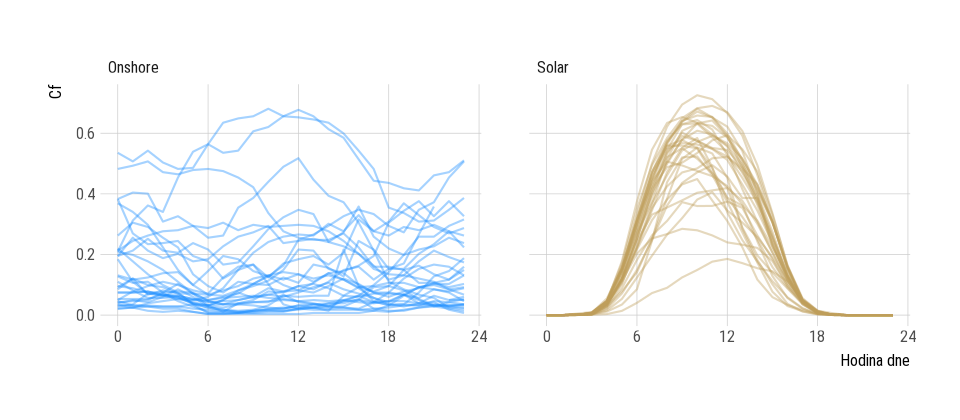

In [57]:
options(repr.plot.height = 3.5, repr.plot.width = 8)

cz_entsoe |>
  filter("2016-07-01" <= Date, Date < "2016-08-01") |>
  select(Date, Solar, Onshore) |>
  pivot_longer(!Date, names_to = "Source", values_to = "Cf") |>
  mutate(Hour = hour(Date)) |>
  ggplot(aes(Hour, Cf)) +
  geom_line(
    aes(colour = Source, group = yday(Date)),
    linewidth = .6,
    alpha = .4
  ) +
  scale_x_continuous("Hodina dne", breaks = seq(0, 24, by = 6)) +
  scale_colour_manual(
    guide = "none",
    values = c(Onshore = colour_wind, Solar = colour_solar_dark)
  ) +
  facet_grid(cols = vars(Source))


In [59]:
df_cz_hourly_solar_pecd <- data_file_path("PECD-ERAA2023-LFSolarPV-2025.parquet") |>
  read_parquet() |>
  filter(country == "CZ") |>
  transmute(
    Date = as.POSIXct(str_glue("{year}-{month}-{day} {hour}:00"), tz = "UTC"),
    Solar = cf
  )

df_cz_hourly_wind_pecd <- data_file_path("PECD-ERAA2023-Wind_Onshore-2025.parquet") |>
  read_parquet() |>
  filter(country == "CZ") |>
  mutate(
    # Fix one data issue: the 10 AM problem.
    cf = if_else(hour == 11, (lag(cf) + lead(cf)) / 2, cf)
  ) |>
  transmute(
    Date = as.POSIXct(str_glue("{year}-{month}-{day} {hour}:00"), tz = "UTC"),
    Onshore = cf
  )

df_cz_hourly_both_pecd <- inner_join(
  df_cz_hourly_solar,
  df_cz_hourly_wind,
  join_by(Date)
)


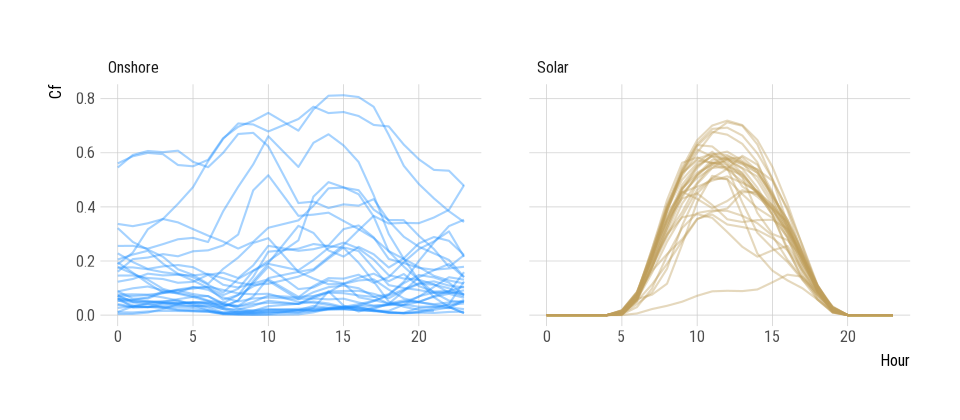

In [60]:
options(repr.plot.height = 3.5, repr.plot.width = 8)

df_cz_hourly_both_pecd |>
  filter("2016-07-01" <= Date, Date < "2016-08-01") |>
  select(Date, Solar, Onshore) |>
  pivot_longer(!Date, names_to = "Source", values_to = "Cf") |>
  mutate(Hour = hour(Date)) |>
  ggplot(aes(Hour, Cf)) +
  geom_line(
    aes(colour = Source, group = yday(Date)),
    linewidth = .6,
    alpha = .4
  ) +
  scale_colour_manual(
    guide = "none",
    values = c(Onshore = colour_wind, Solar = colour_solar_dark)
  ) +
  facet_grid(cols = vars(Source))
